In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [22]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
mx = 0; root = None
for u in range(N):
    if get_size(G, [0] * N, u) > mx:
        mx = get_size(G, [0] * N, u)
        root = u
        
print(root, get_size(G, [0] * N, root), N)

744 4586 4586


In [29]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    VI = [0] * N
    for u in I:
        VI[u] = 1
    
    return [bool(VI[u] + V[u]) for u in range(N)], sum([(VI[u] and not V[u]) for u in range(N)])

def greedyAppReduceDynamicRobust(G, W, V_, root, K, limit, wlim):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight_robust(G, W, V, root, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        E.remove(u)
        
    return ans, tot

In [76]:
def plot_sample_no_intersections(G, V_, sample, geom, _id):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.show()

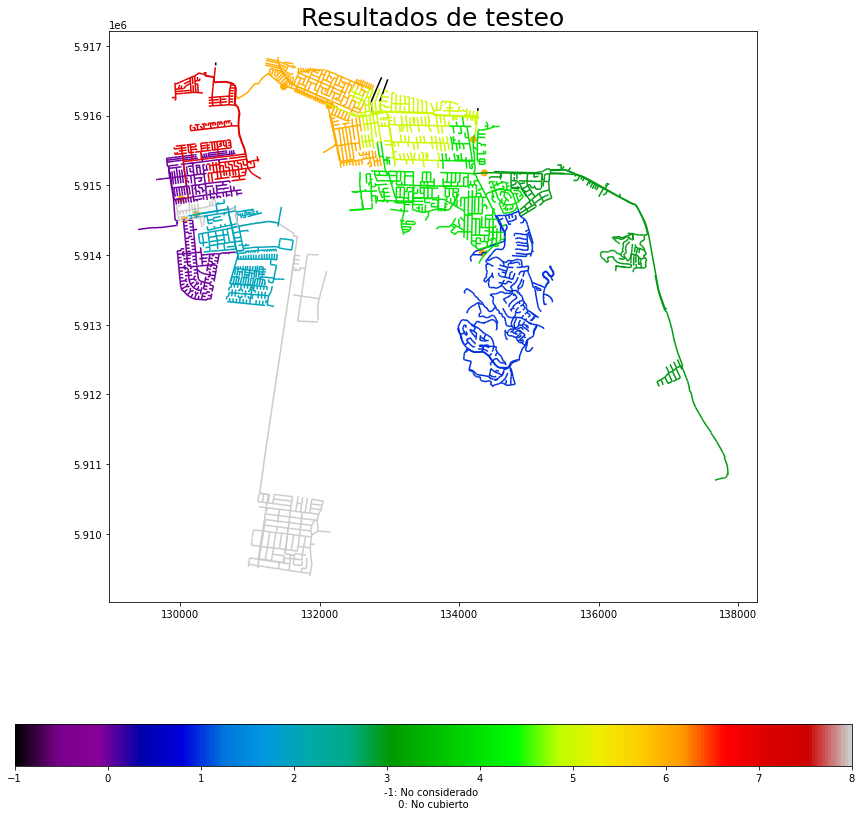

In [77]:
# low = 0; high = N
# while low != high:
#     mid = (low + high) // 2
#     P, sP = greedyAppReduceDynamic(G, W, [0] * N, 8, mid, 1e8)
#     if N - sP < mid:
#         high = mid
#     else:
#         low = mid + 1
        
low = 362
init_P, _ = greedyAppReduceDynamic(G, W, [0] * N, 8, low - 1, 1e8)

plot_sample_no_intersections(G, [0] * N, init_P, geometry, _id)

In [78]:
def simulate_robust(G, W, k2):
    iters = []; N = len(W)
    S = random.sample(range(N), 50)

    for r in S:

        print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            print("it,", t, R)
            
            if t == 0:
                P = init_P
            elif R >= 10:
                low = 0; high = R
                while low != high:
                    mid = (low + high) // 2
                    P, sP = greedyAppReduceDynamic(G, W, V, k2, mid, 1e8)
                    if R - sP < mid:
                        high = mid
                    else:
                        low = mid + 1
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, low, 1e8)
                if low > 1:
                    P_, sP_ = greedyAppReduceDynamicRobust(G, W, V, root, k2, low - 1, 1e8)
                    if abs(sP_ - (low - 1)) < abs(sP - low):
                        P = P_; sP = sP_
            else:
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, 1, 1e8)
    
            plot_sample_no_intersections(G, V, P, geometry, _id)
            print("nx", sum([CV[u] for u in P]), N - sum(V))

            V_ = [0] * N
            for u in P:
                if CV[u]:
                    I = get_ideal(G, V, u)
                    for v in I:
                        V_[v] = 1
                    
            print(sum(V_))

            V_ = [not V_[u] for u in range(N)]
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V_[v] = 1

            V = V_
            
            print(N - sum(V))

            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

2649
it, 0 4586


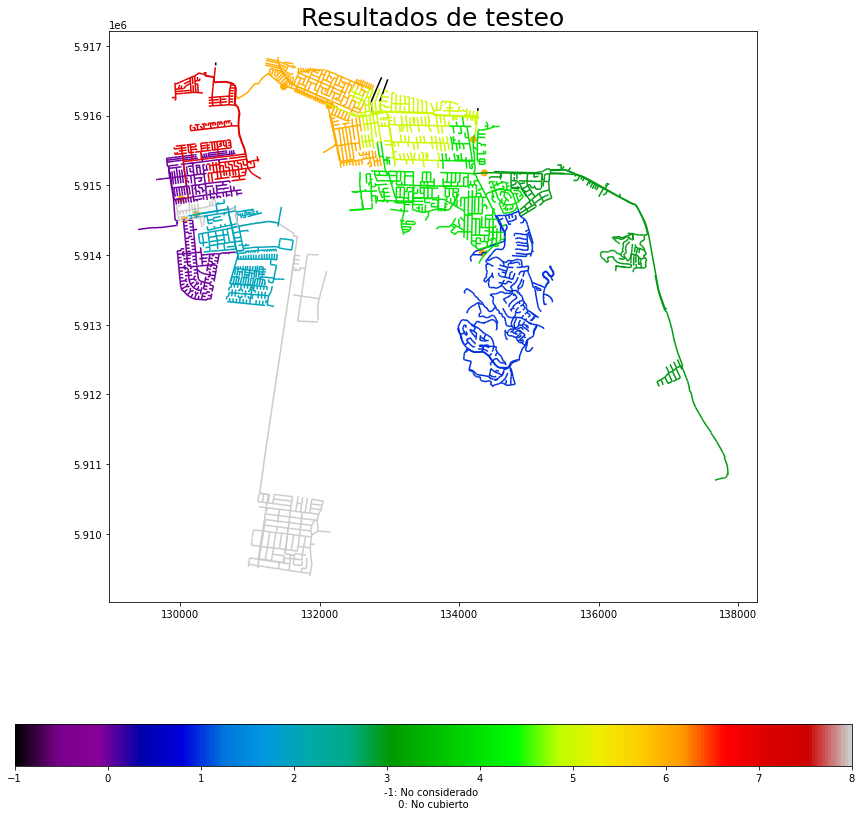

nx 2 4586
762
762
it, 1 762


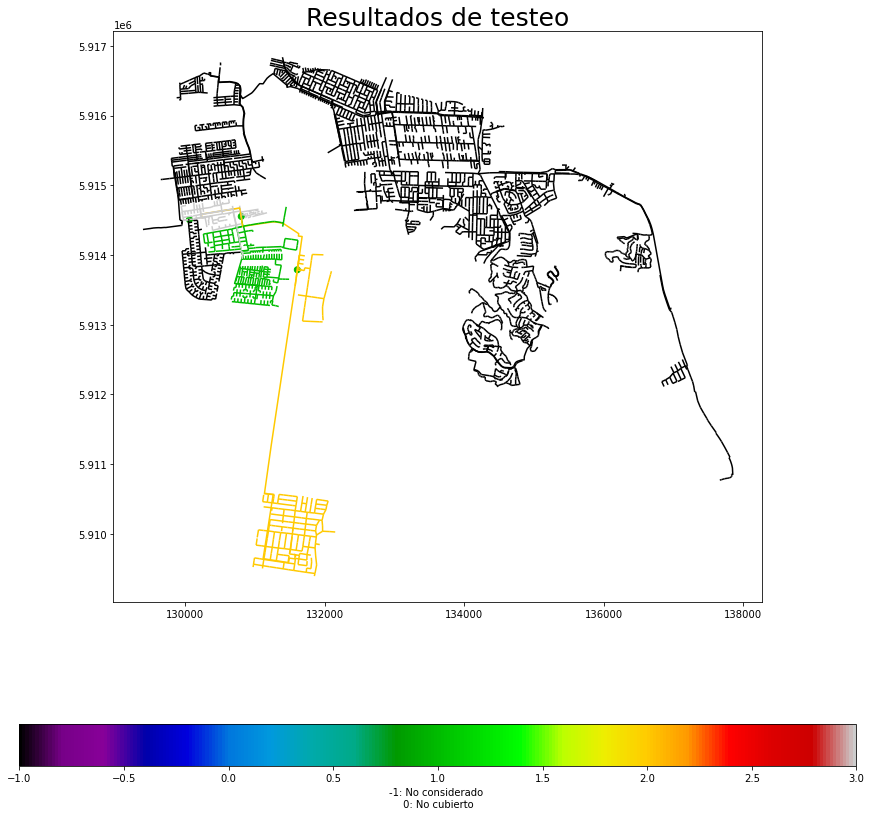

nx 2 762
762
532
it, 2 532


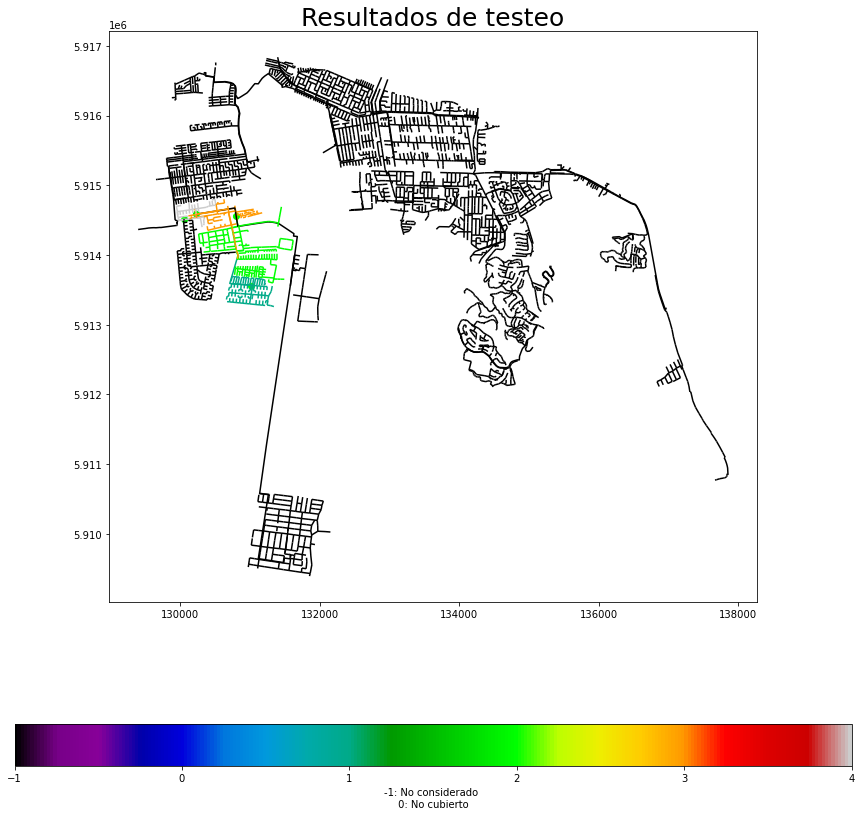

nx 3 532
532
400
it, 3 400


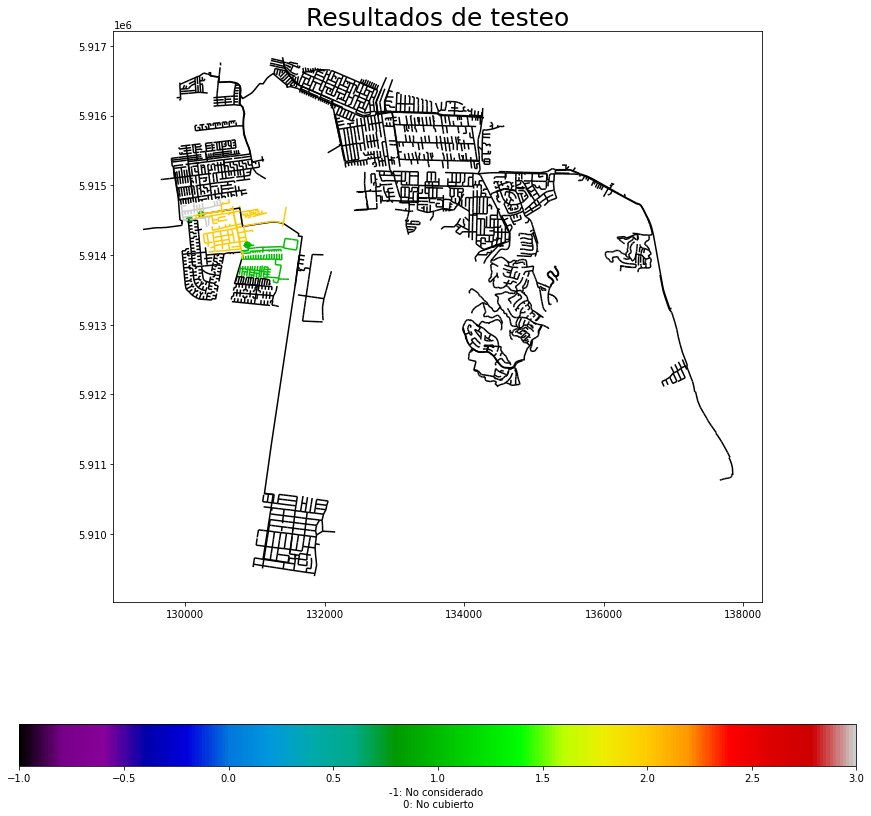

nx 3 400
400
400
it, 4 400


In [ ]:
simulate_robust(G, W, 5)